# **Расчет численного обратного преобразования Лапласа**
**Щербатюк Р.Р.**

In [ ]:
!pip install anaflow

     |████████████████████████████████| 348 kB 10.3 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

In [ ]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    return -1/2*expi(-rd**2 / 4 / td)

In [ ]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

In [ ]:
t_p_hr = 24 # время работы скважины

In [ ]:
def pd_build_up(td, td_p):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    """

    return pd_ei(td) - np.heaviside(td-td_p,1) * pd_ei(td-td_p)
    
      

In [ ]:
t_arr = np.arange(0.01, 48, 0.1)
td_arr=td_from_t(t_arr)
td_prod=td_from_t(t_p_hr)
pd_arr=pd_build_up(td_arr,td_prod)

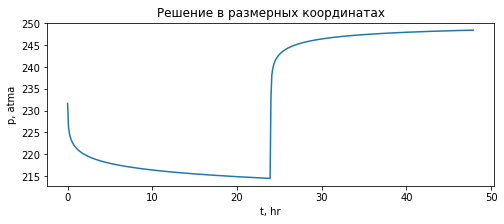

In [ ]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(t_arr, p_from_pd_atma(pd_arr))
plt.xlabel('t, hr')
plt.ylabel('p, atma')
plt.title('Решение в размерных координатах')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


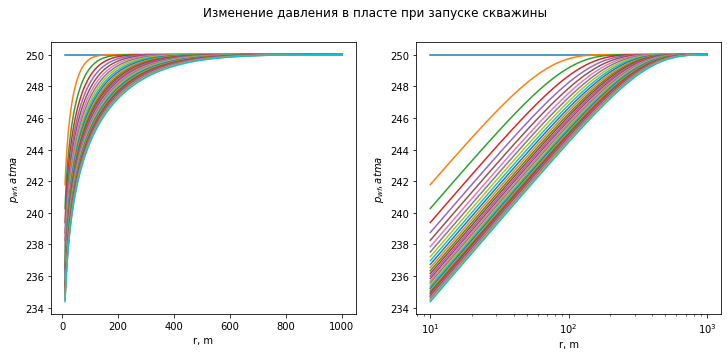

In [ ]:
r_arr = np.logspace(1, 3, 100)
t_arr = np.arange(0.01, 30, 1)
t_arr[0] = 0
t_prod = 24

tv, rv = np.meshgrid(td_from_t(t_arr),rd_from_r(r_arr))
pd_arr =pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


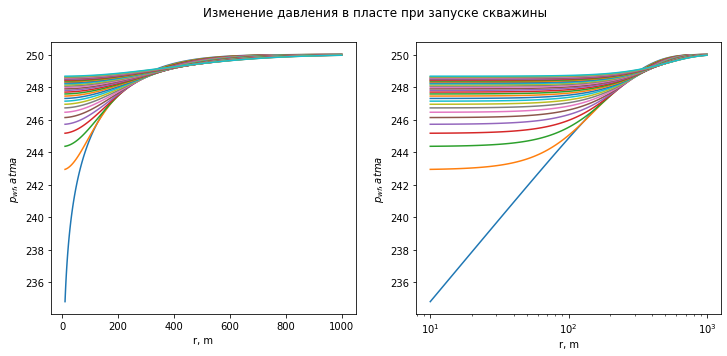

In [ ]:
pd_arr_bu =pd_ei(tv + td_from_t(t_prod), rd=rv) - pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr_bu))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()







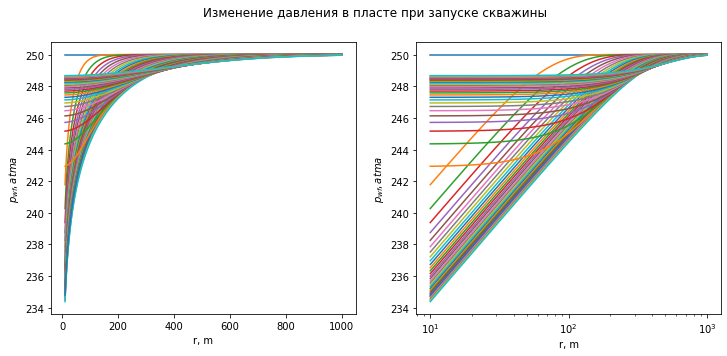

In [ ]:


















fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr,p_from_pd_atma(pd_arr))
ax1.plot(r_arr,p_from_pd_atma(pd_arr_bu))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')
ax2.plot(r_arr,p_from_pd_atma(pd_arr))
ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu))

ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

In [ ]:
# создадим историю изменения дебитов 

t_history = np.array([ 0., 2., 24. ], dtype=np.float64) 
q_history = np.array([10., 5., 0.], dtype=np.float64)

# массивы должны быть одной и той же длины

In [ ]:
def pd_superposition(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([0, qd_hist])
    tdh = np.hstack([0, td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([0, np.diff(qdh)])
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    dpd = np.cumsum(qd_v * pd_ei((td_v - tdh)) * np.heaviside((td_v - tdh), 1),1 )

    return dpd[:,-1]


def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

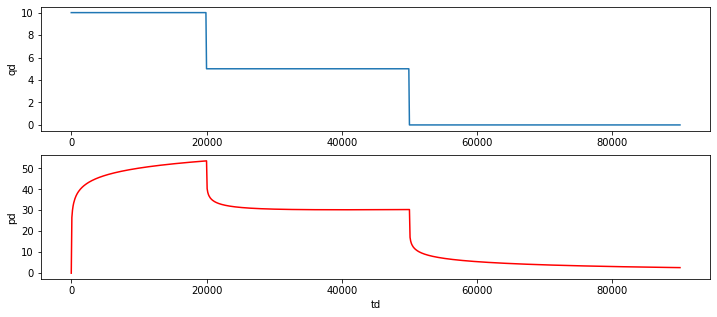

In [ ]:
td_arr = np.linspace(1e-3, 9e4, 1000)


td_history = np.array([ 0., 2e4, 5e4 ], dtype=np.float64) 
qd_history = np.array([10., 5., 0.], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history), color='red') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()









In [ ]:









def p_superposition_atma(t_hr, t_hist_hr, q_hist_sm3day):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    q_ref=10.
    return p_from_pd_atma(pd_superposition(td_from_t(t_hr),
                                           td_from_t(t_hist_hr),
                                           q_hist_sm3day / q_ref), 
                          q_sm3day=q_ref)

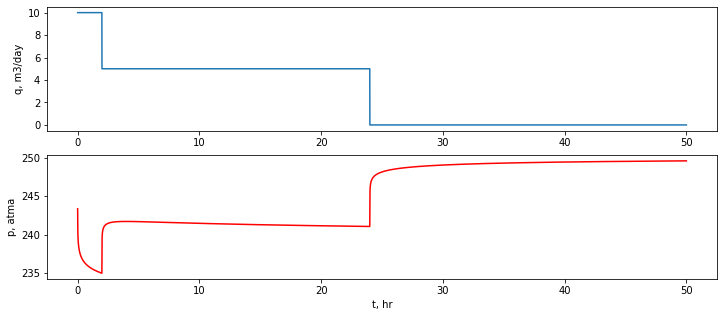

In [ ]:
t_arr = np.arange(1e-3, 50, 1e-2)
plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()


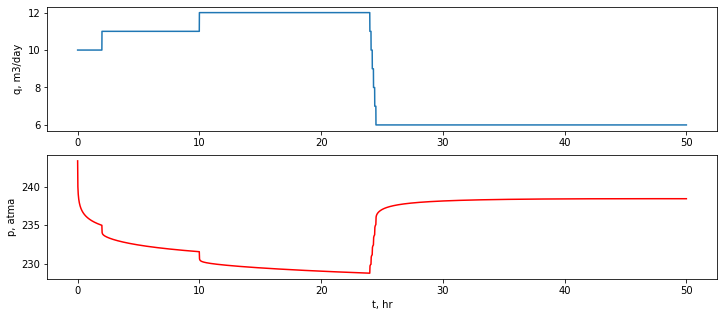

In [ ]:
t_history = np.array([0, 2, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([10, 11, 12, 11, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()